# Statistical Bootstrapping using R and ggplot2

by [Max Woolf](http://minimaxir.com)

Based on the [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers) talk by Jake VanderPlas.

In [22]:
options(warn=-1)

# IMPORTANT: This assumes that all packages in "Rstart.R" are installed,
# and the fonts "Source Sans Pro" and "Open Sans Condensed Bold" are installed
# via extrafont. If ggplot2 charts fail to render, you may need to change/remove the theme call.

source("Rstart.R")
library(tidyr)

options(repr.plot.mimetypes = 'image/png', repr.plot.width=4, repr.plot.height=3, repr.plot.res=300)

# Preparing the Data

Data is manually transcribed from the linked talk, and converted to a `tbl_df`.

In [3]:
x <- c(8.1, 8.4, 8.8, 8.7, 9, 9.1, 9.2, 9.3, 9.4, 9.6, 9.9, 10, 10, 10.5, 10.6, 10.6, 11.2, 11.8, 12.6)
y <- c(21, 19, 18, 16, 15, 17, 17, 17, 19, 14, 14, 15, 11, 12, 12, 13, 10, 8, 9)

df <- tbl_df(data.frame(x,y))
df

,x,y
1,8.1,21
2,8.4,19
3,8.8,18
4,8.7,16
5,9,15
6,9.1,17
7,9.2,17
8,9.3,17
9,9.4,19
10,9.6,14


Let's create a quick plot in ggplot2 to compare it to the source image:

![](http://i.imgur.com/Qim8J6R.png)

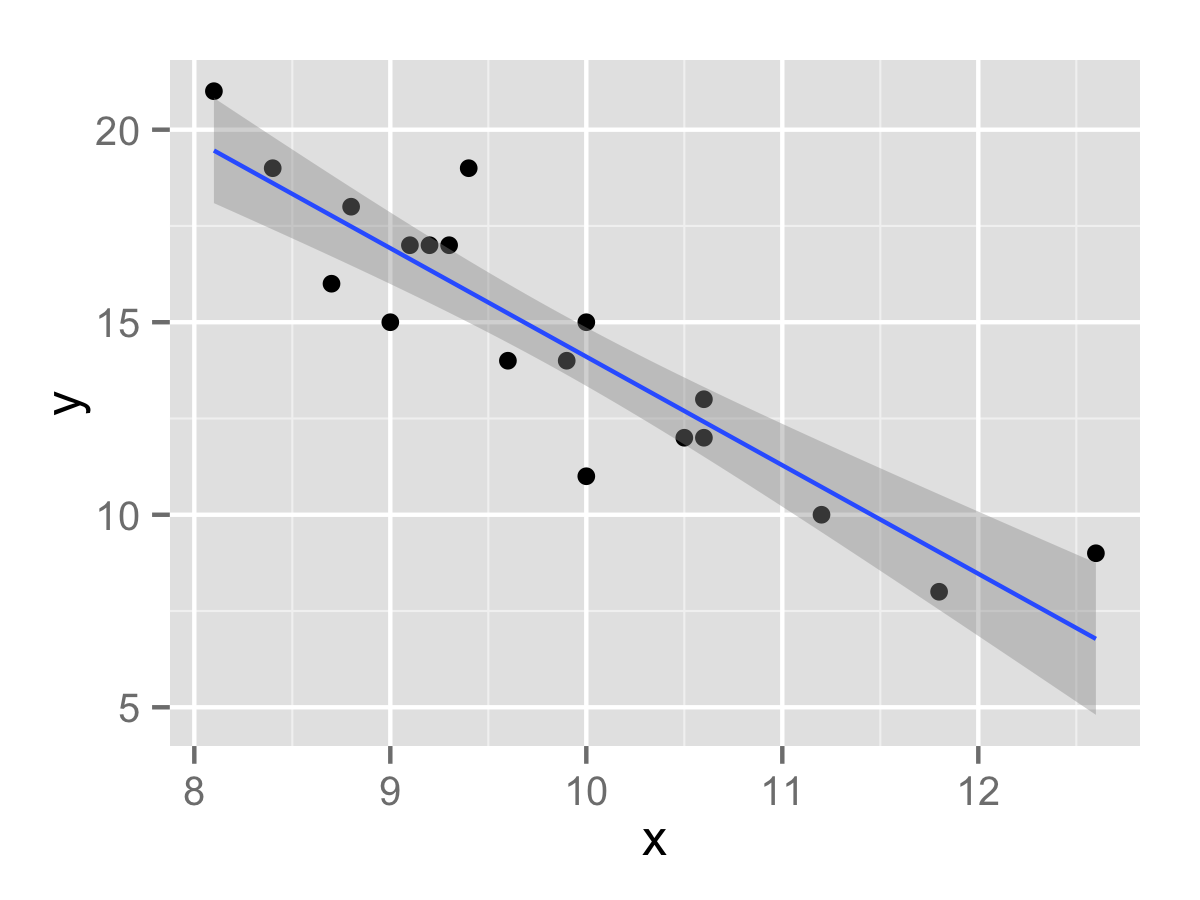

In [4]:
qplot(x, y, df) + geom_smooth(method="lm")

Pretty good, for one line of code!

Let's perform the linear regression within R itself to validate the model:

In [5]:
model_base <- lm(y ~ x, df)
summary(model_base)


Call:
lm(formula = y ~ x, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1043 -0.8767  0.3592  0.7684  3.2047 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  42.2879     3.0928  13.673 1.33e-10 ***
x            -2.8184     0.3125  -9.019 6.87e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.551 on 17 degrees of freedom
Multiple R-squared:  0.8271,	Adjusted R-squared:  0.817 
F-statistic: 81.35 on 1 and 17 DF,  p-value: 6.875e-08


To interpret the output:

* **42.3**, the coefficient for the (Intercept), represents the value of the stack if Wind Speed is 0.
* For every 1 unit increase in Wind Speed, the estimated Height **decreases by 2.81**, the coefficient for the `x` variable.

Both coefficients are extremely statistically significant. Regression as a whole has a R^2 of 82.71%; indicating that the change in Wind Speed explains 82.71% of the variation in Height. That's enough to assert causality in this mock data.

# Resampling the Data

The important thing to consider when resampling data for bootstrapping is to resample *with replacement*. `dplyr` has a conveient resampling tool.

In [7]:
set.seed(4)
df_res <- df %>% sample_frac(replace=T)

df_res

,x,y
1,10,15
2,8.1,21
3,9.1,17
4,9.1,17
5,10.6,13
6,9,15
7,10.5,12
8,11.8,8
9,12.6,9
10,8.4,19


Is the regression model better or worse with this new simulated dataset?

In [8]:
model_res <- lm(y ~ x, df_res)
summary(model_res)


Call:
lm(formula = y ~ x, data = df_res)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3586 -0.2033  0.1201  0.7697  2.6557 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   40.179      1.949   20.61 1.83e-13 ***
x             -2.536      0.189  -13.41 1.80e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.247 on 17 degrees of freedom
Multiple R-squared:  0.9137,	Adjusted R-squared:  0.9086 
F-statistic: 179.9 on 1 and 17 DF,  p-value: 1.799e-10


Intercept coefficient is lower (40.2 vs. 42.3), but the slope coeficient has a lower magnitude (-2.54 vs. -2.81). There is a tradeoff between the two coefficients.

Notably, the R^2 of this model is much higher. (91.37% vs. 82.71%)

We can create a simple function to resample the data and return the regression coefficients:

In [9]:
lm_res <- function(df) {
    model <- lm(y ~ x, df %>% sample_frac(replace=T))
    return (model$coefficients)
}

set.seed(4)
lm_res(df)

(Intercept)           x 
  40.179238   -2.535632

# Performing the Bootstrap

R's `replicate` function runs a function a specified amount of times and stores the results in the same data frame; perfect for bootstrapping.

In [11]:
boot <- replicate(5, lm_res(df))

boot

(Intercept),48.31225,35.67431,42.31093,48.37466,39.29018
x,-3.452915,-2.115819,-2.814033,-3.409116,-2.486155


There's no limit to the number of repetitions needed; however, you can hit diminishing returns quickly. Generally, 2000 trials are recommended, but let's do 10000 trials just to be sure. (It's also recommended to time replications using `system.time` for benchmarking)

Additionally, we need the data transposed so the variable represent columns, which is important for aggregation later.

In [16]:
system.time( df_boot <- replicate(10000, lm_res(df)) )
df_boot <- tbl_df(data.frame(t(df_boot)))

df_boot %>% head(5)
sprintf("Number of Bootstraped Samples: %s", nrow(df_boot))

   user  system elapsed 
 13.490   0.106  13.739 

,X.Intercept.,x
1,41.68011,-2.772336
2,42.25146,-2.82176
3,43.1374,-2.93011
4,38.81379,-2.44351
5,44.99409,-3.075069


[1] "Number of Bootstraped Samples: 10000"

Now we can build 95% confidence intervals for each coefficient. This is done by finding the 2.5% quartile, and the 97.5% quartile; since there are a very large amount of bootstrapped samples, the confidence interval will be very accurate.

This can be done easily using the `gather` function from `tidyr` to convert the data from wide to long, and `dplyr`'s aggregation and mutation functions.

In [19]:
df_boot_agg <- df_boot %>%
                gather(var, value) %>%
                group_by(var) %>%
                summarize(
                    average = mean(value),
                    low_ci = quantile(value, 0.025),
                    high_ci = quantile(value, 0.975)
                        )

df_boot_agg

,var,average,low_ci,high_ci
1,X.Intercept.,42.8287,36.87797,49.29228
2,x,-2.876489,-3.533629,-2.280779


Therefore, the true value of the X intercept has a 95% chance of being between 36.9 and 49.3, and the true value of the Wind Speed coefficient has a 95% chance of being between -3.53 and -2.28

# Plotting the Bootstrap of One Variable

The Wind Speed coefficient is much more interesting, statistically. We have enough information to derive a ggplot2 histogram of the resampled data, and a graphical representation of the confidence interval. We can also include the true value of the coefficient in the visualization to see if it make sense.

Note the *order* when plotting in ggplot2 matters!

In [25]:
plot <- ggplot(df_boot, aes(x=x)) +
    scale_x_continuous(limits=c(-4,-2)) +
    scale_y_continuous(breaks=pretty_breaks(4)) +
    annotate("rect", xmin=as.numeric(df_boot_agg[2,3]), xmax=as.numeric(df_boot_agg[2,4]), ymin=0, ymax=Inf, color="#999999", fill="#1a1a1a", alpha=0.10) +
    annotate("text", label=sprintf("%0.2f",as.numeric(df_boot_agg[2,3])), x=as.numeric(df_boot_agg[2,3]), y=Inf, vjust=2, hjust=1.5, color="#999999", size=2, family="Open Sans Condensed Bold") +
    annotate("text", label=sprintf("%0.2f",as.numeric(df_boot_agg[2,4])), x=as.numeric(df_boot_agg[2,4]), y=Inf, vjust=2, hjust=-0.5, color="#999999", size=2, family="Open Sans Condensed Bold") +
    geom_histogram(binwidth=0.1, fill="#2980b9") +
    geom_vline(xintercept = model_base$coef[2], color="#2c3e50", size=0.5, linetype="dashed") +
    fte_theme() +
    labs(title=sprintf("Bootstrap Resampling of Height ~ Wind Speed (n = %2d)", nrow(df_boot)), x="Coefficient of Wind Speed", y="# of Resampled Regressions w/ Coefficient")

max_save(plot, "uni_one", "@jakevdp")

![](uni_one.png)

Plot is close to a Normal distribution / bell curve, which is a nice property of bootstrapping and makes the results easier to analyze. The true coefficient value is in the interval, but not quite at the center.

Now using the resampling code and plotting code above, we can write a function to generate a plot for different data size subsets. This shows the impact of bootstrapping and how the confidence estimate intervals converge as the number of trials increases.

The frames are input into another folder `uni_frames` for conversion into a GIF.

In [27]:
system("mkdir -p uni_frames")

uni_frame <- function(size) {
    df_boot_sub <- df_boot %>% head(size)
    
    df_boot_agg_sub <- df_boot_sub %>%
                gather(var, value) %>%
                group_by(var) %>%
                summarize(
                    average = mean(value),
                    low_ci = quantile(value, 0.025),
                    high_ci = quantile(value, 0.975)
                        )

plot <- ggplot(df_boot_sub, aes(x=x)) +
    scale_x_continuous(limits=c(-4,-2)) +
    scale_y_continuous(breaks=pretty_breaks(4)) +
    annotate("rect", xmin=as.numeric(df_boot_agg_sub[2,3]), xmax=as.numeric(df_boot_agg_sub[2,4]), ymin=0, ymax=Inf, color="#999999", fill="#1a1a1a", alpha=0.10) +
    annotate("text", label=sprintf("%0.2f",as.numeric(df_boot_agg_sub[2,3])), x=as.numeric(df_boot_agg_sub[2,3]), y=Inf, vjust=2, hjust=1.5, color="#999999", size=2, family="Open Sans Condensed Bold") +
    annotate("text", label=sprintf("%0.2f",as.numeric(df_boot_agg_sub[2,4])), x=as.numeric(df_boot_agg_sub[2,4]), y=Inf, vjust=2, hjust=-0.5, color="#999999", size=2, family="Open Sans Condensed Bold") +
    geom_histogram(binwidth=0.1, fill="#2980b9") +
    geom_vline(xintercept = model_base$coef[2], color="#2c3e50", size=0.5, linetype="dashed") +
    fte_theme() +
    labs(title=sprintf("Bootstrap Resampling of Height ~ Wind Speed (n = %2d)", size), x="Coefficient of Wind Speed", y="# of Resampled Regressions w/ Coefficient")

max_save(plot, sprintf("uni_frames/uni_%06d", size), "@jakevdp")

}

Now let's make the frames! We'll create a frame for every 100 sample increase in the data set size, starting at 100, for 99 frames total.

In [28]:
system.time( x <- lapply(seq(100,10000,100), uni_frame) )

   user  system elapsed 
 49.962   1.564  54.094 

The frames are then converted using my [Convert Frame to Video OS X tool](https://github.com/minimaxir/frames-to-gif-osx) (R has an `animation` package that does not utilize as many optimizations), which results in a nice GIF half a MB!

![](uni_frames.gif)

From the GIF, it's clear to see that the confidence intervals converge to the final values at about 2000 trials, with the shape of the distribution stabalizing at about 7000 trials.

# Plotting the Bootstrap of Two Variables

The X-intercept and the Wind Speed coefficient have a linked relationship, so it makes sense to plot them simultaneously, as in the original talk.

![](http://i.imgur.com/09q73zI.png)

ggplot2's `density2d` plots a contour map, which will help illustrate the area and magnitude where the data converges on a 2D plane. We can also include an **orange** bounding box using the specified values for the confidence intervals for each variable, and a **red** dot representing the true value of the coefficients.

In [29]:
plot <- ggplot(df_boot, aes(x=x, y=X.Intercept., fill=..level..)) +
    scale_x_continuous(limits=c(-4,-2)) +
    scale_y_continuous(limits=c(30,60)) +
    geom_density2d(color="#1a1a1a") +
    stat_density2d(aes(fill = ..level..), geom="polygon") +
    annotate("rect", xmin=as.numeric(df_boot_agg[2,3]), xmax=as.numeric(df_boot_agg[2,4]), ymin=as.numeric(df_boot_agg[1,3]), ymax=as.numeric(df_boot_agg[1,4]), color="#e67e22", fill="#1a1a1a", alpha=0.0) +
    annotate("point", x=model_base$coef[2], y=model_base$coef[1], color="#e9594b") +
    fte_theme() +
    labs(title=sprintf("Density of Resampling of Height ~ Wind Speed (n = %2d)", nrow(df_boot)), x="Coefficient of Wind Speed", y="Value of X Intercept")

max_save(plot, "bi_one", "@jakevdp")

![](bi_one.png)

The pair of coefficients can only occur in a certain range of values, much smaller than the bounding box. The true value is close to the most frequent occurence, too.

Now to run a similar frame-generation procedure for the bivariate GIF.

In [30]:
system("mkdir -p bi_frames")

bi_frame <- function(size) {
    df_boot_sub <- df_boot %>% head(size)

    df_boot_agg_sub <- df_boot_sub %>%
                gather(var, value) %>%
                group_by(var) %>%
                summarize(
                average = mean(value),
                    low_ci = quantile(value, 0.025),
                    high_ci = quantile(value, 0.975)
                        )

plot <- ggplot(df_boot_sub, aes(x=x, y=X.Intercept., fill=..level..)) +
    scale_x_continuous(limits=c(-4,-2)) +
    scale_y_continuous(limits=c(30,60)) +
    geom_density2d(color="#1a1a1a") +
    stat_density2d(aes(fill = ..level..), geom="polygon") +
    annotate("rect", xmin=as.numeric(df_boot_agg_sub[2,3]), xmax=as.numeric(df_boot_agg_sub[2,4]), ymin=as.numeric(df_boot_agg_sub[1,3]), ymax=as.numeric(df_boot_agg_sub[1,4]), color="#e67e22", fill="#1a1a1a", alpha=0.0) +
    annotate("point", x=model_base$coef[2], y=model_base$coef[1], color="#e9594b") +
    fte_theme() +
    labs(title=sprintf("Density of Resampling of Height ~ Wind Speed (n = %2d)", size), x="Coefficient of Wind Speed", y="Value of X Intercept")

max_save(plot, sprintf("bi_frames/bi_%06d", size), "@jakevdp")
    
}


Now the final step!

In [31]:
system.time( x <- lapply(seq(100,10000,100), bi_frame) )

   user  system elapsed 
117.865   4.492 127.699 

Took twice as long to render the frames as the univariate case, but it's worth it!

![](bi_frames.gif)

Again, the visualization converges relatively quickly.